## Tutorial of Patching Patching, Causal Scrubbing

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/frankaging/pyvene/blob/main/tutorials/basic_tutorials/Basic_Intervention.ipynb)

In [1]:
__author__ = "Aryaman Arora and Zhengxuan Wu"
__version__ = "10/05/2023"

### Overview

This tutorial aims to reproduce some of the results in this [notebook](https://github.com/aryamanarora/nano-causal-interventions/blob/main/The%20capital%20of%20France%20is.ipynb) for path patching or causal scrubbing. This library could potentially support other kinds of interventions that were not originally supported by previous works.

### Set-up

In [2]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import pyvene

except ModuleNotFoundError:
    !pip install pyvene

In [3]:
import pandas as pd
from pyvene import embed_to_distrib, top_vals, format_token
from pyvene import IntervenableRepresentationConfig, IntervenableConfig, IntervenableModel
from pyvene import VanillaIntervention
from pyvene.models.gpt2.modelings_intervenable_gpt2 import create_gpt2

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
)

### Factual recall

In [4]:
config, tokenizer, gpt = create_gpt2(cache_dir="../../../.huggingface_cache")

base = "The capital of Spain is"
source = "The capital of Italy is"
inputs = [tokenizer(base, return_tensors="pt"), tokenizer(source, return_tensors="pt")]
print(base)
res = gpt(**inputs[0])
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)
print()
print(source)
res = gpt(**inputs[1])
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

loaded model
The capital of Spain is
_Madrid              0.10501296818256378
_the                 0.09496472775936127
_Barcelona           0.07027896493673325
_a                   0.04010061174631119
_now                 0.028243593871593475
_in                  0.027600279077887535
_Spain               0.022992031648755074
_Catalonia           0.018823478370904922
_also                0.01868910901248455
_not                 0.0173567533493042

The capital of Italy is
_Rome                0.15734177827835083
_the                 0.07316122949123383
_Milan               0.04688136279582977
_a                   0.03450017422437668
_now                 0.0320034995675087
_in                  0.023065155372023582
_also                0.022747963666915894
_home                0.01920326240360737
_not                 0.01640525832772255
_Italy               0.015770886093378067


### Patch Patching on Position-aligned Tokens
We path patch on two modules on each layer:
- [1] MLP output (the MLP output will be from another example)
- [2] MHA input (the self-attention module input will be from another module)

In [5]:
def simple_position_config(model_type, intervention_type, layer):
    intervenable_config = IntervenableConfig(
        intervenable_model_type=model_type,
        intervenable_representations=[
            IntervenableRepresentationConfig(
                layer,  # layer
                intervention_type,  # intervention type
                "pos",  # intervention unit
                1,  # max number of unit
            ),
        ],
        intervenable_interventions_type=VanillaIntervention,
    )
    return intervenable_config


base = tokenizer("The capital of Spain is", return_tensors="pt")
sources = [tokenizer("The capital of Italy is", return_tensors="pt")]

In [6]:
# should finish within 1 min with a standard 12G GPU
tokens = tokenizer.encode(" Madrid Rome")

data = []
for layer_i in range(gpt.config.n_layer):
    intervenable_config = simple_position_config(type(gpt), "mlp_output", layer_i)
    intervenable = IntervenableModel(intervenable_config, gpt)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = intervenable(
            base, sources, {"sources->base": ([[[pos_i]]], [[[pos_i]]])}
        )
        distrib = embed_to_distrib(
            gpt, counterfactual_outputs.last_hidden_state, logits=False
        )
        for token in tokens:
            data.append(
                {
                    "token": format_token(tokenizer, token),
                    "prob": float(distrib[0][-1][token]),
                    "layer": f"f{layer_i}",
                    "pos": pos_i,
                    "type": "mlp_output",
                }
            )

    intervenable_config = simple_position_config(type(gpt), "attention_input", layer_i)
    intervenable = IntervenableModel(intervenable_config, gpt)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = intervenable(
            base, sources, {"sources->base": ([[[pos_i]]], [[[pos_i]]])}
        )
        distrib = embed_to_distrib(
            gpt, counterfactual_outputs.last_hidden_state, logits=False
        )
        for token in tokens:
            data.append(
                {
                    "token": format_token(tokenizer, token),
                    "prob": float(distrib[0][-1][token]),
                    "layer": f"a{layer_i}",
                    "pos": pos_i,
                    "type": "attention_input",
                }
            )
df = pd.DataFrame(data)

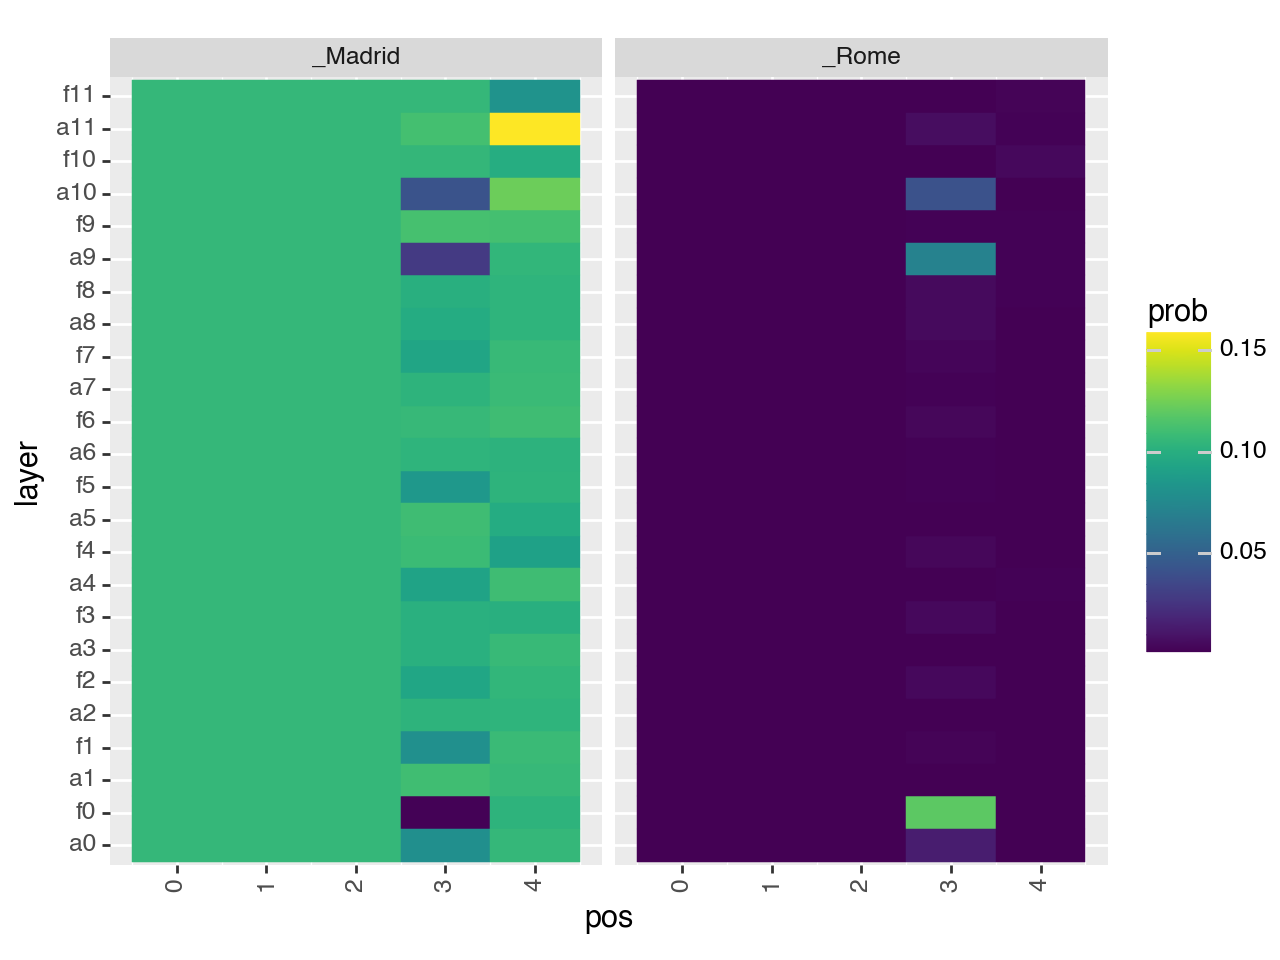

In [7]:
df["layer"] = df["layer"].astype("category")
df["token"] = df["token"].astype("category")
nodes = []
for l in range(gpt.config.n_layer - 1, -1, -1):
    nodes.append(f"f{l}")
    nodes.append(f"a{l}")
df["layer"] = pd.Categorical(df["layer"], categories=nodes[::-1], ordered=True)

g = (
    ggplot(df)
    + geom_tile(aes(x="pos", y="layer", fill="prob", color="prob"))
    + facet_wrap("~token")
    + theme(axis_text_x=element_text(rotation=90))
)
print(g)

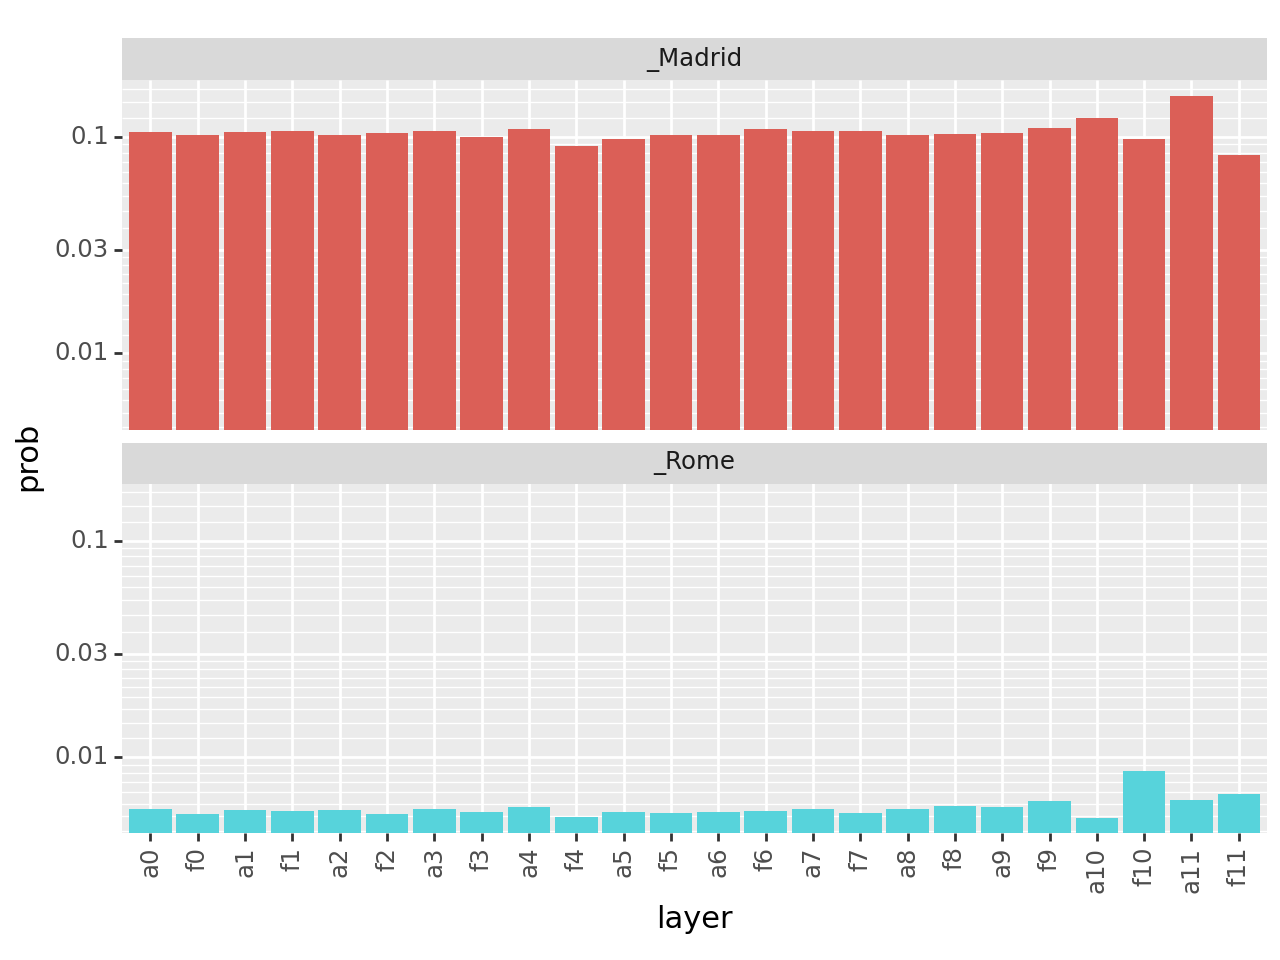

In [9]:
filtered = df
filtered = filtered[filtered["pos"] == 4]
g = (
    ggplot(filtered)
    + geom_bar(aes(x="layer", y="prob", fill="token"), stat="identity")
    + theme(axis_text_x=element_text(rotation=90), legend_position="none")
    + scale_y_log10()
    + facet_wrap("~token", ncol=1)
)
print(g)